<a href="https://colab.research.google.com/github/EliasEconomou/DataMining2-Travel-Time-Prediction/blob/main/DataMining2_Travel_Time_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries and Reading Files**

In [1]:
import numpy as np
import pandas as pd
import sys
import os.path
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Options
pd.options.mode.chained_assignment = None


In [3]:
# Read data files
def read_file(filePath):
  fileExists = os.path.exists(filePath)
  if fileExists:
    rFile = pd.read_csv(filePath)
  else:
    print('Enter data file path:')
    filePath = input()
    rFile = pd.read_csv(filePath)
  return rFile

In [4]:
# Reading train/test/target data files
trainFilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/train.csv"
testFilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/test.csv"
targetFilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/target.csv"


In [5]:
train = read_file(trainFilePath)
test = read_file(testFilePath)
target = read_file(targetFilePath)

train.dropna(inplace = True)
test.dropna(inplace = True)
target.dropna(inplace = True)

print(train.shape,test.shape,target.shape)

(1166915, 11) (291729, 9) (291729, 2)


In [6]:
# Choose a subset - percentage of the dataset's rows
def select_dfsubset(initDF, percentage):
  numOfRows = initDF.shape[0]
  newDF = initDF.iloc[:int(percentage*0.01*numOfRows)]
  return newDF

# **Analyzing Data**

In [7]:
# We can choose a subset of our train-test dataset to analyze
percentage = 10
trainDF = select_dfsubset(train,percentage)
print("Chosen number of travels is {} - {}% of the given train-dataset.".format(trainDF.shape[0], percentage))
testDF = select_dfsubset(test,percentage)
print("Chosen number of travels is {} - {}% of the given test-dataset.".format(testDF.shape[0], percentage))

Chosen number of travels is 116691 - 10% of the given train-dataset.
Chosen number of travels is 29172 - 10% of the given test-dataset.


##*1. Removing outliers*

In [8]:
# Getting some basic statistics of out dataset with trip duration outliers
statistics = trainDF.describe()
tripDurMean = statistics["trip_duration"]["mean"]
tripDurStd = statistics["trip_duration"]["std"]
statistics

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,116691.000000,116691.000000,116691.000000,116691.000000,116691.000000,116691.000000,116691.000000
mean,1.534197,1.662682,-73.973484,40.751012,-73.973288,40.751984,944.695735
std,0.498831,1.309708,0.039467,0.029052,0.037534,0.033347,3091.959061
min,1.000000,0.000000,-75.238327,39.923027,-74.705360,40.271030,1.000000
25%,1.000000,1.000000,-73.991806,40.737358,-73.991280,40.736092,396.000000
50%,2.000000,1.000000,-73.981827,40.754120,-73.979691,40.754536,662.000000
75%,2.000000,2.000000,-73.967377,40.768368,-73.962990,40.769896,1073.000000
max,2.000000,6.000000,-70.851616,43.017578,-70.851616,43.017578,86362.000000


In [9]:
# Trip duration outlier is considered to be every value 2 standard deviations
# away from the mean
upperOutlier = tripDurMean+2*tripDurStd
lowerOutlier = tripDurMean-2*tripDurStd

is_outlier = np.where((trainDF.trip_duration >= upperOutlier) | (trainDF.trip_duration <= lowerOutlier),"outlier","inlier")
isOutlier = list(is_outlier)
print("Number of outliers is {}.".format(isOutlier.count("outlier")))


Number of outliers is 171.


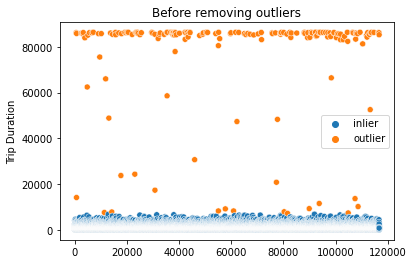

In [10]:
# x-axis values
x_values = range(trainDF.trip_duration.shape[0])

# y-axis values
y_values = trainDF.trip_duration

plotWithOutliers = sns.scatterplot(data=y_values,
                                   y=y_values,
                                   x=x_values,
                                   hue=is_outlier).set(title="Before removing outliers",
                                                       ylabel = "Trip Duration")


In [11]:
# Now let's remove all rows with trip duration outliers
trainDF = trainDF.drop(trainDF[trainDF.trip_duration > upperOutlier].index)
trainDF = trainDF.drop(trainDF[trainDF.trip_duration < lowerOutlier].index)

# Print the new statistics
newStatistics = trainDF.describe()
newTripDurMean = newStatistics["trip_duration"]["mean"]
newTripDurStd = newStatistics["trip_duration"]["std"]
newStatistics

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,116520.000000,116520.000000,116520.000000,116520.000000,116520.000000,116520.000000,116520.000000
mean,1.533565,1.662144,-73.973483,40.751031,-73.973288,40.751985,833.789264
std,0.498874,1.309090,0.039264,0.028940,0.037533,0.033346,649.310595
min,1.000000,0.000000,-74.705368,40.276291,-74.705360,40.271030,1.000000
25%,1.000000,1.000000,-73.991798,40.737370,-73.991280,40.736092,396.000000
50%,2.000000,1.000000,-73.981827,40.754129,-73.979691,40.754539,661.000000
75%,2.000000,2.000000,-73.967377,40.768372,-73.962990,40.769901,1070.000000
max,2.000000,6.000000,-70.851616,43.017578,-70.851616,43.017578,6900.000000


In [12]:
# Compute new outliers
newUpperOutlier = tripDurMean+2*tripDurStd
newLowerOutlier = tripDurMean-2*tripDurStd

new_is_outlier = np.where((trainDF.trip_duration >= newUpperOutlier) | (trainDF.trip_duration <= newLowerOutlier),"outlier","inlier")

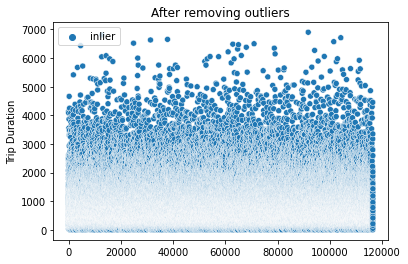

In [13]:
# x-axis values
x_values = range(trainDF.trip_duration.shape[0])

# y-axis values
y_values = trainDF.trip_duration

plotWithOutliers = sns.scatterplot(data=y_values,
                                   y=y_values,
                                   x=x_values,
                                   hue=new_is_outlier).set(title="After removing outliers",
                                                       ylabel = "Trip Duration")

##*2. Remove any points outside NY*

In [14]:
# NY longitude border is (-74.03, -73.75) and latitude border is (40.63, 40.85)
# Keep borders
minLongBorder = -74.03
maxLongBorder = -73.75
minLatBorder = 40.63
maxLatBorder = 40.85

# Minimum and maximum values before removal
min_pickupLong = min(trainDF.pickup_longitude)
max_pickupLong = max(trainDF.pickup_longitude)
min_dropoffLong = min(trainDF.dropoff_longitude)
max_dropoffLong = max(trainDF.dropoff_longitude)

min_pickupLat = min(trainDF.pickup_latitude)
max_pickupLat = max(trainDF.pickup_latitude)
min_dropoffLat = min(trainDF.dropoff_latitude)
max_dropoffLat = max(trainDF.dropoff_latitude)

trainDF.shape

(116520, 11)

In [15]:
trainDF = trainDF.drop(trainDF[trainDF.pickup_longitude < minLongBorder].index)
trainDF = trainDF.drop(trainDF[trainDF.pickup_longitude > maxLongBorder].index)
trainDF = trainDF.drop(trainDF[trainDF.dropoff_longitude < minLongBorder].index)
trainDF = trainDF.drop(trainDF[trainDF.dropoff_longitude > maxLongBorder].index)

trainDF = trainDF.drop(trainDF[trainDF.pickup_latitude < minLatBorder].index)
trainDF = trainDF.drop(trainDF[trainDF.pickup_latitude > maxLatBorder].index)
trainDF = trainDF.drop(trainDF[trainDF.dropoff_latitude < minLatBorder].index)
trainDF = trainDF.drop(trainDF[trainDF.dropoff_latitude > maxLatBorder].index)


In [16]:
# Minimum and maximum values after removal
new_min_pickupLong = min(trainDF.pickup_longitude)
new_max_pickupLong = max(trainDF.pickup_longitude)
new_min_dropoffLong = min(trainDF.dropoff_longitude)
new_max_dropoffLong = max(trainDF.dropoff_longitude)

new_min_pickupLat = min(trainDF.pickup_latitude)
new_max_pickupLat = max(trainDF.pickup_latitude)
new_min_dropoffLat = min(trainDF.dropoff_latitude)
new_max_dropoffLat = max(trainDF.dropoff_latitude)

trainDF.shape

(114927, 11)

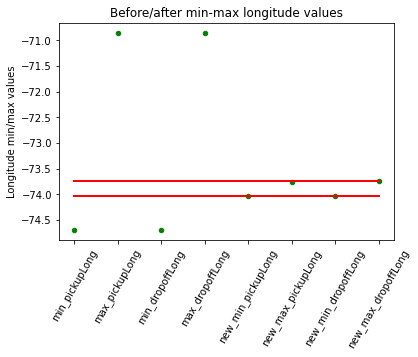

In [17]:
# Now lets plot before/after min-max longitude values
x_coordinates = ["min_pickupLong", "max_pickupLong", "min_dropoffLong", 
                 "max_dropoffLong", "new_min_pickupLong", "new_max_pickupLong",
                 "new_min_dropoffLong", "new_max_dropoffLong"]
y_coordinates = [min_pickupLong, max_pickupLong, min_dropoffLong,
                 max_dropoffLong, new_min_pickupLong, new_max_pickupLong,
                 new_min_dropoffLong, new_max_dropoffLong]

plt.scatter(x_coordinates, y_coordinates, color='g', s=20)
plt.xticks(fontsize=15)
plt.xticks(rotation = 60, fontsize=10) 
plt.ylabel('Longitude min/max values') 
plt.title('Before/after min-max longitude values')
plot_long = plt.plot([0, 7], [minLongBorder, minLongBorder], linewidth=2, color="red")
plot_long = plt.plot([0, 7], [maxLongBorder, maxLongBorder], linewidth=2, color="red")


The red lines represent the longitude limits of NY. The minimum/maximum values surpassed these limits, but after cleaning the new values are within the borders thus we only kept travels strictly inside NY. Same applies for latitude.

##*3. Date time analysis*

In [18]:
# Convert date string to timestamp for both train and test datasets
trainDF["pickup_datetime"] =  pd.to_datetime(trainDF["pickup_datetime"], infer_datetime_format=True)
trainDF["dropoff_datetime"] =  pd.to_datetime(trainDF["dropoff_datetime"], infer_datetime_format=True)
testDF["pickup_datetime"] =  pd.to_datetime(testDF["pickup_datetime"], infer_datetime_format=True)

In [19]:
# We 'll use these functions to create a few time related columns

def create_day_period(datetime):
  if (datetime.hour >= 6) & (datetime.hour <= 11):
    return "Morning"
  elif (datetime.hour >= 12) & (datetime.hour <= 15):
    return "Afternoon"
  elif (datetime.hour >= 16) & (datetime.hour <= 21):
    return "Evening"
  else:
    return "Late Night"

def create_day_name(datetime):
  return datetime.day_name()

def create_month(datetime):
  if (datetime.month == 1):
    return "January"
  elif (datetime.month == 2):
    return "February"
  elif (datetime.month == 3):
    return "March"
  elif (datetime.month == 4):
    return "April"
  elif (datetime.month == 5):
    return "May"
  elif (datetime.month == 6):
    return "June"
  elif (datetime.month == 7):
    return "July"
  elif (datetime.month == 8):
    return "August"
  elif (datetime.month == 9):
    return "September"
  elif (datetime.month == 10):
    return "Octomber"
  elif (datetime.month == 11):
    return "November"
  elif (datetime.month == 12):
    return "December"
  return datetime.month

def create_hour(datetime):
  return datetime.hour

def create_year(datetime):
  return datetime.year

def create_season(datetime):
  if (datetime.month >= 3) & (datetime.month <= 5):
    return "Spring"
  if (datetime.month >= 6) & (datetime.month <= 8):
    return "Summer"
  if (datetime.month >= 9) & (datetime.month <= 11):
    return "Autumn"
  else:
    return "Winter"


In [20]:
# Adding day period columns
trainDF["pickup_day_period"] = trainDF["pickup_datetime"].apply(lambda datetime: create_day_period(datetime))
trainDF["dropoff_day_period"] = trainDF["dropoff_datetime"].apply(lambda datetime: create_day_period(datetime))
testDF["pickup_day_period"] = testDF["pickup_datetime"].apply(lambda datetime: create_day_period(datetime))

# Adding day name columns
trainDF["pickup_day_name"] = trainDF["pickup_datetime"].apply(lambda datetime: create_day_name(datetime))
trainDF["dropoff_day_name"] = trainDF["dropoff_datetime"].apply(lambda datetime: create_day_name(datetime))
testDF["pickup_day_name"] = testDF["pickup_datetime"].apply(lambda datetime: create_day_name(datetime))

# Adding month columns
trainDF["pickup_month"] = trainDF["pickup_datetime"].apply(lambda datetime: create_month(datetime))
trainDF["dropoff_month"] = trainDF["dropoff_datetime"].apply(lambda datetime: create_month(datetime))
testDF["pickup_month"] = testDF["pickup_datetime"].apply(lambda datetime: create_month(datetime))

# Adding hour columns
trainDF["pickup_hour"] = trainDF["pickup_datetime"].apply(lambda datetime: create_hour(datetime))
trainDF["dropoff_hour"] = trainDF["dropoff_datetime"].apply(lambda datetime: create_hour(datetime))
testDF["pickup_hour"] = testDF["pickup_datetime"].apply(lambda datetime: create_hour(datetime))

# Adding year columns
trainDF["pickup_year"] = trainDF["pickup_datetime"].apply(lambda datetime: create_year(datetime))
trainDF["dropoff_year"] = trainDF["dropoff_datetime"].apply(lambda datetime: create_year(datetime))
testDF["pickup_year"] = testDF["pickup_datetime"].apply(lambda datetime: create_year(datetime))


# Adding season columns
trainDF["pickup_season"] = trainDF["pickup_datetime"].apply(lambda datetime: create_season(datetime))
trainDF["dropoff_season"] = trainDF["dropoff_datetime"].apply(lambda datetime: create_season(datetime))
testDF["pickup_season"] = testDF["pickup_datetime"].apply(lambda datetime: create_season(datetime))


### Most busy pickup days

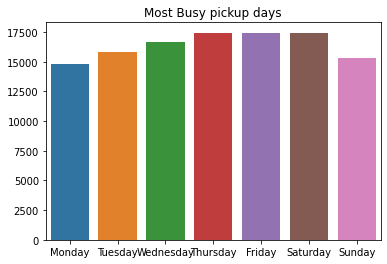

In [21]:
pDaysDict = {}
pDaysDict['Monday'] = trainDF[trainDF.pickup_day_name == "Monday"].shape[0]
pDaysDict['Tuesday'] = trainDF[trainDF.pickup_day_name == "Tuesday"].shape[0]
pDaysDict['Wednesday'] = trainDF[trainDF.pickup_day_name == "Wednesday"].shape[0]
pDaysDict['Thursday'] = trainDF[trainDF.pickup_day_name == "Thursday"].shape[0]
pDaysDict['Friday'] = trainDF[trainDF.pickup_day_name == "Friday"].shape[0]
pDaysDict['Saturday'] = trainDF[trainDF.pickup_day_name == "Saturday"].shape[0]
pDaysDict['Sunday'] = trainDF[trainDF.pickup_day_name == "Sunday"].shape[0]



busyDaysPlot = sns.barplot(x=list(pDaysDict.keys()),
                           y=list(pDaysDict.values())).set(title='Most Busy pickup days')
sns.set(rc={'figure.figsize':(8,4)})


### Most busy dropoff days

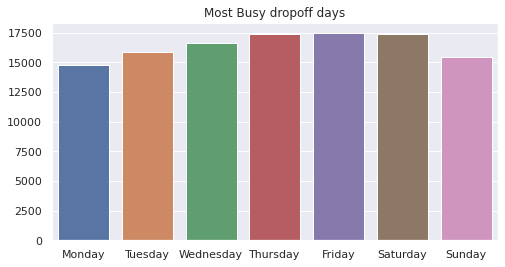

In [22]:
dDaysDict = {}
dDaysDict['Monday'] = trainDF[trainDF.dropoff_day_name == "Monday"].shape[0]
dDaysDict['Tuesday'] = trainDF[trainDF.dropoff_day_name == "Tuesday"].shape[0]
dDaysDict['Wednesday'] = trainDF[trainDF.dropoff_day_name == "Wednesday"].shape[0]
dDaysDict['Thursday'] = trainDF[trainDF.dropoff_day_name == "Thursday"].shape[0]
dDaysDict['Friday'] = trainDF[trainDF.dropoff_day_name == "Friday"].shape[0]
dDaysDict['Saturday'] = trainDF[trainDF.dropoff_day_name == "Saturday"].shape[0]
dDaysDict['Sunday'] = trainDF[trainDF.dropoff_day_name == "Sunday"].shape[0]



busyDaysPlot = sns.barplot(x=list(dDaysDict.keys()),
                           y=list(dDaysDict.values())).set(title='Most Busy dropoff days')
sns.set(rc={'figure.figsize':(8,4)})

### Trips per day period

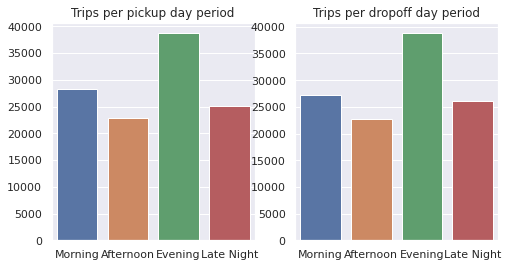

In [23]:
pDayPeriodDict = {}
pDayPeriodDict['Morning'] = trainDF[trainDF.pickup_day_period == "Morning"].shape[0]
pDayPeriodDict['Afternoon'] = trainDF[trainDF.pickup_day_period == "Afternoon"].shape[0]
pDayPeriodDict['Evening'] = trainDF[trainDF.pickup_day_period == "Evening"].shape[0]
pDayPeriodDict['Late Night'] = trainDF[trainDF.pickup_day_period == "Late Night"].shape[0]

dDayPeriodDict = {}
dDayPeriodDict['Morning'] = trainDF[trainDF.dropoff_day_period == "Morning"].shape[0]
dDayPeriodDict['Afternoon'] = trainDF[trainDF.dropoff_day_period == "Afternoon"].shape[0]
dDayPeriodDict['Evening'] = trainDF[trainDF.dropoff_day_period == "Evening"].shape[0]
dDayPeriodDict['Late Night'] = trainDF[trainDF.dropoff_day_period == "Late Night"].shape[0]

fig, ax = plt.subplots(1,2)
pDayPeriodPlot = sns.barplot(x=list(pDayPeriodDict.keys()),
                             y=list(pDayPeriodDict.values()),
                             ax=ax[0]).set(title='Trips per pickup day period')
dDayPeriodPlot = sns.barplot(x=list(dDayPeriodDict.keys()),
                             y=list(dDayPeriodDict.values()),
                             ax=ax[1]).set(title='Trips per dropoff day period')
sns.set(rc={'figure.figsize':(9,4)})
fig.show()

### Trips per day month

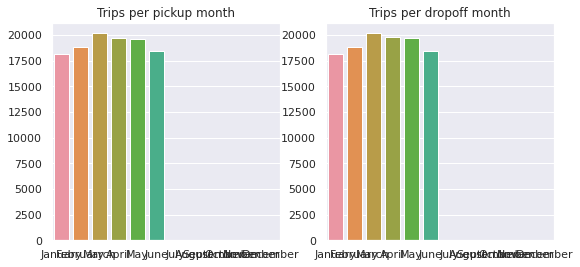

In [24]:
pMonthDict = {}
pMonthDict['January'] = trainDF[trainDF.pickup_month == "January"].shape[0]
pMonthDict['February'] = trainDF[trainDF.pickup_month == "February"].shape[0]
pMonthDict['March'] = trainDF[trainDF.pickup_month == "March"].shape[0]
pMonthDict['April'] = trainDF[trainDF.pickup_month == "April"].shape[0]
pMonthDict['May'] = trainDF[trainDF.pickup_month == "May"].shape[0]
pMonthDict['June'] = trainDF[trainDF.pickup_month == "June"].shape[0]
pMonthDict['July'] = trainDF[trainDF.pickup_month == "July"].shape[0]
pMonthDict['August'] = trainDF[trainDF.pickup_month == "August"].shape[0]
pMonthDict['September'] = trainDF[trainDF.pickup_month == "September"].shape[0]
pMonthDict['Octomber'] = trainDF[trainDF.pickup_month == "Octomber"].shape[0]
pMonthDict['November'] = trainDF[trainDF.pickup_month == "November"].shape[0]
pMonthDict['December'] = trainDF[trainDF.pickup_month == "December"].shape[0]

dMonthDict = {}
dMonthDict['January'] = trainDF[trainDF.dropoff_month == "January"].shape[0]
dMonthDict['February'] = trainDF[trainDF.dropoff_month == "February"].shape[0]
dMonthDict['March'] = trainDF[trainDF.dropoff_month == "March"].shape[0]
dMonthDict['April'] = trainDF[trainDF.dropoff_month == "April"].shape[0]
dMonthDict['May'] = trainDF[trainDF.dropoff_month == "May"].shape[0]
dMonthDict['June'] = trainDF[trainDF.dropoff_month == "June"].shape[0]
dMonthDict['July'] = trainDF[trainDF.dropoff_month == "July"].shape[0]
dMonthDict['August'] = trainDF[trainDF.dropoff_month == "August"].shape[0]
dMonthDict['September'] = trainDF[trainDF.dropoff_month == "September"].shape[0]
dMonthDict['Octomber'] = trainDF[trainDF.dropoff_month == "Octomber"].shape[0]
dMonthDict['November'] = trainDF[trainDF.dropoff_month == "November"].shape[0]
dMonthDict['December'] = trainDF[trainDF.dropoff_month == "December"].shape[0]

fig, ax = plt.subplots(1,2)
pMonthPlot = sns.barplot(x=list(pMonthDict.keys()),
                             y=list(pMonthDict.values()),
                             ax=ax[0]).set(title='Trips per pickup month')
dMonthPlot = sns.barplot(x=list(dMonthDict.keys()),
                             y=list(dMonthDict.values()),
                             ax=ax[1]).set(title='Trips per dropoff month')
sns.set(rc={'figure.figsize':(9,4)})
fig.show()